In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    

from IPython.display import IFrame
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.patches as patches
import warnings
import networkx as nx
import osmnx as ox
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
ox.config(use_cache=True, log_console=True)
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from IPython.display import IFrame


%matplotlib inline
%load_ext autoreload
%autoreload 2

# IFrame(src='https://commons.pratt.edu/savi/', width=700, height=400)

In [3]:
import urllib

In [4]:
file_url = 'https://s3.amazonaws.com/tripdata/202003-citibike-tripdata.csv.zip'

In [5]:
urllib.request.urlretrieve(file_url, 'data/input/202003-citibike-tripdata.zip')

('data/input/202003-citibike-tripdata.zip',
 <http.client.HTTPMessage at 0x108985850>)

In [6]:
import zipfile

In [7]:
zipfile.ZipFile(f'data/input/202003-citibike-tripdata.zip').extractall(f'data/input/')

In [8]:
citibike = pd.read_csv('data/input/202003-citibike-tripdata.csv')

In [9]:
citibike.head(2)

tripduration                 starttime                  stoptime  \
0          1589  2020-03-01 00:00:03.6400  2020-03-01 00:26:32.9860   
1           389  2020-03-01 00:00:16.7560  2020-03-01 00:06:46.0620   

   start station id     start station name  start station latitude  \
0               224  Spruce St & Nassau St               40.711464   
1               293  Lafayette St & E 8 St               40.730207   

   start station longitude  end station id             end station name  \
0               -74.005524            3574  Prospect Pl & Underhill Ave   
1               -73.991026             223              W 13 St & 7 Ave   

   end station latitude  end station longitude  bikeid    usertype  \
0             40.676969             -73.965790   16214  Subscriber   
1             40.737815             -73.999947   29994  Subscriber   

   birth year  gender  
0        1980       1  
1        1991       2

In [10]:
citibike.dtypes

tripduration                 int64
starttime                   object
stoptime                    object
start station id             int64
start station name          object
start station latitude     float64
start station longitude    float64
end station id               int64
end station name            object
end station latitude       float64
end station longitude      float64
bikeid                       int64
usertype                    object
birth year                   int64
gender                       int64
dtype: object

In [11]:
citibike['starttime'] = pd.to_datetime(citibike['starttime'])

In [12]:
citibike['stoptime'] = pd.to_datetime(citibike['stoptime'])

In [13]:
citibike['start_day'] = citibike['starttime'].map(lambda x: x.day)

In [14]:
citibike['end_day'] = citibike['stoptime'].map(lambda x: x.day)

In [15]:
citibike['end_day_2'] = citibike['stoptime'].dt.date

In [16]:
citibike['start_day_2'] = citibike['starttime'].dt.date

In [17]:
citibike['start_hour'] = citibike['starttime'].dt.hour

In [18]:
citibike['end_hour'] = citibike['stoptime'].dt.hour

In [19]:
citibike.shape

(1068457, 21)

## data check- every station only has 1 lat long, for start station and end station

In [20]:
citibike.head(2)

tripduration               starttime                stoptime  \
0          1589 2020-03-01 00:00:03.640 2020-03-01 00:26:32.986   
1           389 2020-03-01 00:00:16.756 2020-03-01 00:06:46.062   

   start station id     start station name  start station latitude  \
0               224  Spruce St & Nassau St               40.711464   
1               293  Lafayette St & E 8 St               40.730207   

   start station longitude  end station id             end station name  \
0               -74.005524            3574  Prospect Pl & Underhill Ave   
1               -73.991026             223              W 13 St & 7 Ave   

   end station latitude  ...  bikeid    usertype birth year  gender  \
0             40.676969  ...   16214  Subscriber       1980       1   
1             40.737815  ...   29994  Subscriber       1991       2   

   start_day  end_day   end_day_2 start_day_2 start_hour  end_hour  
0          1        1  2020-03-01  2020-03-01          0         0  
1          1        1  2020-03-01  2020-03-01          0         0  

[2 rows x 21 columns]

In [21]:
number_pickups = citibike.groupby(["start station name", "start station latitude" , "start station longitude", "start_day", "start_hour"]).size().to_frame('size').reset_index()

In [22]:
number_pickups

start station name  start station latitude  \
0                   1 Ave & E 110 St               40.792327   
1                   1 Ave & E 110 St               40.792327   
2                   1 Ave & E 110 St               40.792327   
3                   1 Ave & E 110 St               40.792327   
4                   1 Ave & E 110 St               40.792327   
...                              ...                     ...   
291670  Wythe Ave & Metropolitan Ave               40.716887   
291671  Wythe Ave & Metropolitan Ave               40.716887   
291672  Wythe Ave & Metropolitan Ave               40.716887   
291673  Wythe Ave & Metropolitan Ave               40.716887   
291674  Wythe Ave & Metropolitan Ave               40.716887   

        start station longitude  start_day  start_hour  size  
0                    -73.938300          1           7     1  
1                    -73.938300          1          11     1  
2                    -73.938300          1          14     3  
3                    -73.938300          1          15     1  
4                    -73.938300          1          21     1  
...                         ...        ...         ...   ...  
291670               -73.963198         31          13     1  
291671               -73.963198         31          17     3  
291672               -73.963198         31          18     1  
291673               -73.963198         31          19     2  
291674               -73.963198         31          21     1  

[291675 rows x 6 columns]

In [23]:
number_dropoffs = citibike.groupby(["end station name", "end station latitude" , "end station longitude", "end_day", "end_hour"]).size().to_frame('size').reset_index()

In [24]:
number_dropoffs.rename(columns={'end station name' : 'station name',
                                'end station latitude': 'station latitude',
                                'end station longitude': 'station longitude',
                                'end_day':'day',
                                'end_hour': 'hour',
                                'size': 'number_dropoffs'}, inplace=True)

In [25]:
number_pickups.rename(columns={'start station name' : 'station name',
                               'start station latitude': 'station latitude',
                               'start station longitude': 'station longitude',
                               'start_day': 'day',
                               'start_hour': 'hour',
                              'size': 'number_pickups'}, inplace=True)

In [26]:
number_dropoffs.head(2)

station name  station latitude  station longitude  day  hour  \
0  1 Ave & E 110 St         40.792327           -73.9383    1     0   
1  1 Ave & E 110 St         40.792327           -73.9383    1     2   

   number_dropoffs  
0                1  
1                2

In [27]:
number_pickups.head(2)

station name  station latitude  station longitude  day  hour  \
0  1 Ave & E 110 St         40.792327           -73.9383    1     7   
1  1 Ave & E 110 St         40.792327           -73.9383    1    11   

   number_pickups  
0               1  
1               1

In [28]:
start_complete_test = number_pickups.merge(number_dropoffs,
                                           how='outer',
                                           on=['station name', 'station latitude', 'station longitude',
                                               'day', 'hour'])

In [29]:
start_complete_test.sort_values(by = ['day', 'hour'], ascending=True)

station name  station latitude  station longitude  day  \
358            1 Ave & E 16 St         40.732219         -73.981656    1   
957            1 Ave & E 18 St         40.733812         -73.980544    1   
1511           1 Ave & E 30 St         40.741444         -73.975361    1   
2961           1 Ave & E 62 St         40.761227         -73.960940    1   
3513           1 Ave & E 68 St         40.765005         -73.958185    1   
...                        ...               ...                ...  ...   
358987  W 76 St & Columbus Ave         40.780184         -73.977285   31   
359751  W Broadway & Spring St         40.724947         -74.001659   31   
359851      Wall St & South St         40.704370         -74.006370   31   
361023  West End Ave & W 94 St         40.794165         -73.974124   31   
361126          West Thames St         40.708347         -74.017134   31   

        hour  number_pickups  number_dropoffs  
358        0             4.0              4.0  
957        0             2.0              1.0  
1511       0             1.0              NaN  
2961       0             1.0              1.0  
3513       0             1.0              NaN  
...      ...             ...              ...  
358987    23             NaN              1.0  
359751    23             NaN              1.0  
359851    23             NaN              2.0  
361023    23             NaN              1.0  
361126    23             NaN              2.0  

[362767 rows x 7 columns]

## check that outer join works as intended

In [30]:


start_complete_test[start_complete_test['station name'] == 'Wythe Ave & Metropolitan Ave'].sort_values(by = ['day','hour'], ascending = False).head(8)

station name  station latitude  station longitude  \
291674  Wythe Ave & Metropolitan Ave         40.716887         -73.963198   
291673  Wythe Ave & Metropolitan Ave         40.716887         -73.963198   
291672  Wythe Ave & Metropolitan Ave         40.716887         -73.963198   
291671  Wythe Ave & Metropolitan Ave         40.716887         -73.963198   
362766  Wythe Ave & Metropolitan Ave         40.716887         -73.963198   
362765  Wythe Ave & Metropolitan Ave         40.716887         -73.963198   
362764  Wythe Ave & Metropolitan Ave         40.716887         -73.963198   
291670  Wythe Ave & Metropolitan Ave         40.716887         -73.963198   

        day  hour  number_pickups  number_dropoffs  
291674   31    21             1.0              NaN  
291673   31    19             2.0              5.0  
291672   31    18             1.0              3.0  
291671   31    17             3.0              NaN  
362766   31    16             NaN              1.0  
362765   31    15             NaN              5.0  
362764   31    14             NaN              2.0  
291670   31    13             1.0              2.0

In [31]:
citibike[citibike['start station name'] == 
         'Wythe Ave & Metropolitan Ave'].sort_values(by = 'starttime', ascending = False)['starttime'].head(11)

1067766   2020-03-31 21:07:48.489
1067012   2020-03-31 19:51:23.426
1066681   2020-03-31 19:30:42.345
1064909   2020-03-31 18:16:58.916
1064155   2020-03-31 17:51:12.594
1064122   2020-03-31 17:50:06.737
1063108   2020-03-31 17:13:33.555
1058098   2020-03-31 13:06:52.793
1056797   2020-03-31 11:33:57.077
1056300   2020-03-31 10:44:38.808
1056230   2020-03-31 10:36:31.443
Name: starttime, dtype: datetime64[ns]

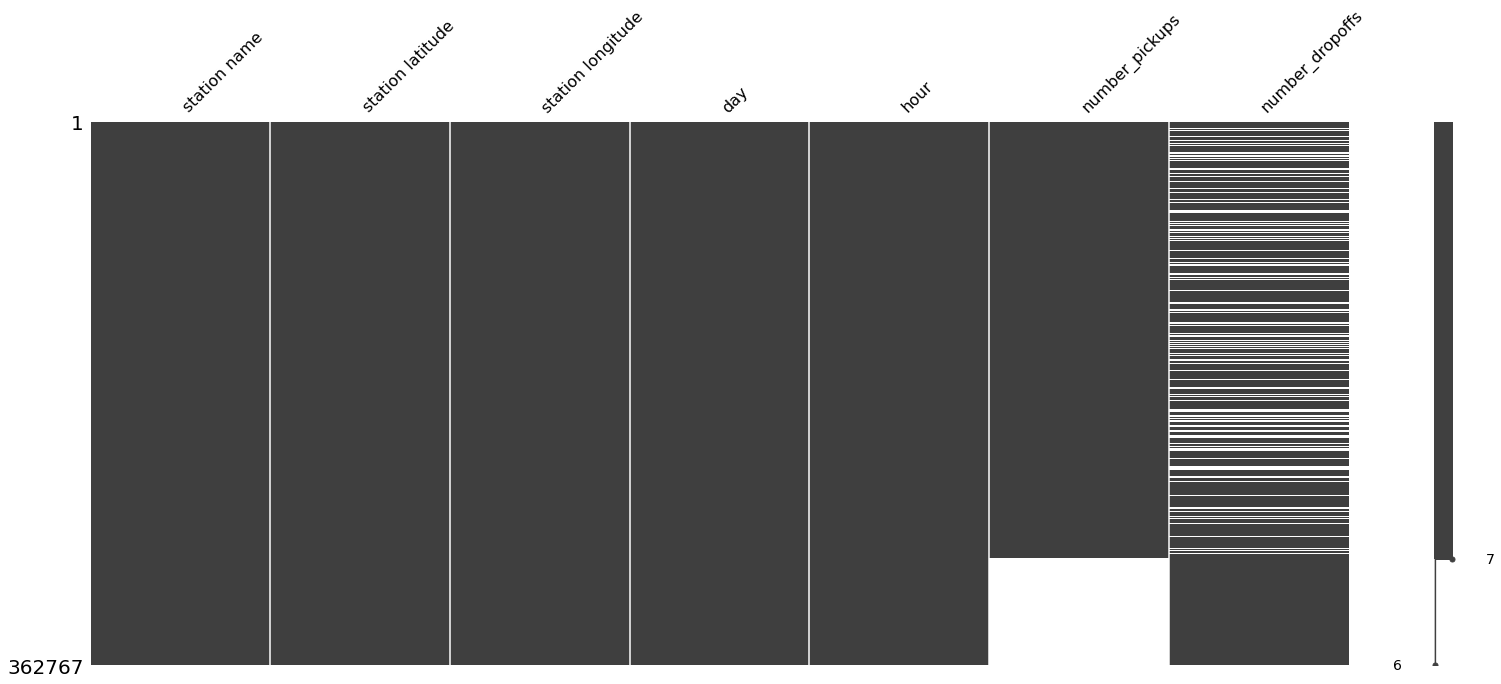

In [32]:
msno.matrix(start_complete_test)

In [33]:
df_citibike = start_complete_test.fillna(0).sort_values(by = ['day','hour','station name'], ascending = True)

In [34]:
from shapely.geometry import Point

## Make geometry column for citibike

In [35]:
df_citibike['geometry'] =df_citibike.apply( lambda row: Point(row['station longitude'], row['station latitude'] ), axis=1)

In [36]:
df_citibike.head()

station name  station latitude  station longitude  day  hour  \
291675  1 Ave & E 110 St         40.792327         -73.938300    1     0   
358      1 Ave & E 16 St         40.732219         -73.981656    1     0   
957      1 Ave & E 18 St         40.733812         -73.980544    1     0   
1511     1 Ave & E 30 St         40.741444         -73.975361    1     0   
2961     1 Ave & E 62 St         40.761227         -73.960940    1     0   

        number_pickups  number_dropoffs  \
291675             0.0              1.0   
358                4.0              4.0   
957                2.0              1.0   
1511               1.0              0.0   
2961               1.0              1.0   

                                           geometry  
291675                  POINT (-73.9383 40.7923272)  
358                POINT (-73.98165557 40.73221853)  
957     POINT (-73.9805442094803 40.73381219196632)  
1511         POINT (-73.97536082000001 40.74144387)  
2961                POINT (-73.96094022 40.7612274)

In [37]:
from geopandas import GeoDataFrame

In [38]:
df_citibike = GeoDataFrame(df_citibike, geometry='geometry')

In [39]:
df_citibike = df_citibike.reset_index()

In [40]:
df_citibike['activity'] = df_citibike['number_pickups'] + df_citibike['number_dropoffs']

In [41]:
df_citibike['net_pickups'] = df_citibike['number_pickups'] - df_citibike['number_dropoffs']

In [42]:
df_citibike.head(5)

index      station name  station latitude  station longitude  day  hour  \
0  291675  1 Ave & E 110 St         40.792327         -73.938300    1     0   
1     358   1 Ave & E 16 St         40.732219         -73.981656    1     0   
2     957   1 Ave & E 18 St         40.733812         -73.980544    1     0   
3    1511   1 Ave & E 30 St         40.741444         -73.975361    1     0   
4    2961   1 Ave & E 62 St         40.761227         -73.960940    1     0   

   number_pickups  number_dropoffs                    geometry  activity  \
0             0.0              1.0  POINT (-73.93830 40.79233)       1.0   
1             4.0              4.0  POINT (-73.98166 40.73222)       8.0   
2             2.0              1.0  POINT (-73.98054 40.73381)       3.0   
3             1.0              0.0  POINT (-73.97536 40.74144)       1.0   
4             1.0              1.0  POINT (-73.96094 40.76123)       2.0   

   net_pickups  
0         -1.0  
1          0.0  
2          1.0  
3          1.0  
4          0.0

In [43]:
df_citibike.shape

(362767, 11)

In [44]:
df_citibike.crs = {'init' :'epsg:4326'}

In [45]:
df_citibike = df_citibike.to_crs(epsg=2263)

In [46]:
df_citibike.head()

index      station name  station latitude  station longitude  day  hour  \
0  291675  1 Ave & E 110 St         40.792327         -73.938300    1     0   
1     358   1 Ave & E 16 St         40.732219         -73.981656    1     0   
2     957   1 Ave & E 18 St         40.733812         -73.980544    1     0   
3    1511   1 Ave & E 30 St         40.741444         -73.975361    1     0   
4    2961   1 Ave & E 62 St         40.761227         -73.960940    1     0   

   number_pickups  number_dropoffs                        geometry  activity  \
0             0.0              1.0  POINT (1001334.533 227949.114)       1.0   
1             4.0              4.0   POINT (989334.101 206044.065)       8.0   
2             2.0              1.0   POINT (989641.982 206624.752)       3.0   
3             1.0              0.0   POINT (991077.725 209405.575)       1.0   
4             1.0              1.0   POINT (995070.581 216614.806)       2.0   

   net_pickups  
0         -1.0  
1          0.0  
2          1.0  
3          1.0  
4          0.0

# Looking at the sum of daily citibike traffic throughout March

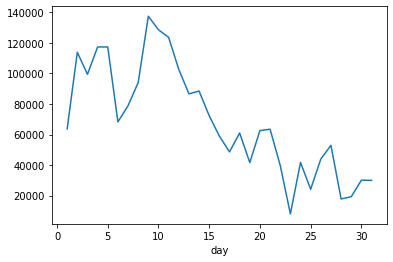

In [47]:
popular_days = df_citibike.groupby(['day'])['activity'].agg('sum')

type(popular_days)

popular_days.plot();

In [135]:
week1 = df_citibike.loc[df_citibike['day'].isin([2,3,4,5,6])]
week2 = df_citibike.loc[df_citibike['day'].isin([23,24,25,26,27])]

In [136]:
day_of_week = {2:'Mon',3:'Tue',4:'Wed',5:'Thur',6:'Fri'}
day_of_week2 = {23:'Mon',24:'Tue',25:'Wed',26:'Thur',27:'Fri'}

In [137]:
week1 = week1.groupby(['day','hour'])['activity'].agg('sum').reset_index()
week2 = week2.groupby(['day','hour'])['activity'].agg('sum').reset_index()

In [152]:
week1['day_of_week'] = week1['day'].map(day_of_week) 
week1['day_hour'] = week1["day"].astype(str) + "-" + week1["hour"].astype(str)
week2['day_of_week'] = week2['day'].map(day_of_week2) 
week2['day_hour'] = week2["day"].astype(str) + "-" + week2["hour"].astype(str)

In [153]:
week1

day  hour  activity day_of_week day_hour
0      2     0     468.0         Mon      2-0
1      2     1     232.0         Mon      2-1
2      2     2     121.0         Mon      2-2
3      2     3     111.0         Mon      2-3
4      2     4     179.0         Mon      2-4
..   ...   ...       ...         ...      ...
115    6    19    2506.0         Fri     6-19
116    6    20    2021.0         Fri     6-20
117    6    21    1451.0         Fri     6-21
118    6    22    1135.0         Fri     6-22
119    6    23     919.0         Fri     6-23

[120 rows x 5 columns]

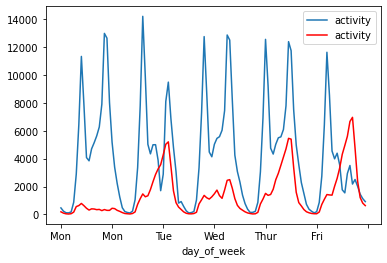

In [160]:
ax = plt.gca()

week1.plot(kind='line',x='day_of_week', y='activity',ax=ax)
week2.plot(kind='line',y='activity',x='day_of_week', color='red', ax=ax)

plt.show();

# to normalize any future graphics displayed over time, I want to know the max and min activity for any given hour this month

In [48]:
activity_max = df_citibike['activity'].max()

In [49]:
activity_max

207.0

In [50]:
activity_min = df_citibike['activity'].min()

In [51]:
activity_min

1.0

# Part B: merge with Neighborhoods

In [52]:
from urllib.request import urlopen
import json

In [53]:
nyc_nta_geojson = 'https://data.cityofnewyork.us/api/geospatial/cpf4-rkhq?method=export&format=GeoJSON'


nta_gdf = gpd.read_file(nyc_nta_geojson)
nta_gdf = nta_gdf.to_crs(epsg=2263)

In [353]:
nta_gdf.head(2)

ntacode    shape_area county_fips       ntaname     shape_leng boro_name  \
0    BK88  54005019.048         047  Borough Park  39247.2278309  Brooklyn   
1    QN51  52488277.846         081   Murray Hill  33266.9047967    Queens   

  boro_code                                           geometry  
0         3  MULTIPOLYGON (((990897.900 169268.121, 990588....  
1         4  MULTIPOLYGON (((1038593.459 221913.355, 103936...

In [55]:
nta_gdf.drop(nta_gdf[nta_gdf['boro_name'] == 'Staten Island'].index, inplace=True)

In [56]:
nta_gdf.shape

(176, 8)

### Join data

In [57]:
   bikes_in_nyc = gpd.sjoin(  # sjoin stands for spatial join
       
        df_citibike,
       nta_gdf,
        how='right',
        op='intersects',
    )

In [58]:
bikes_in_nyc = bikes_in_nyc.drop(['index_left'], axis=1)

In [346]:
# bikes_in_nyc = bikes_in_nyc.drop(['index'], axis=1)

In [59]:
bikes_in_nyc.head()

index       station name  station latitude  station longitude   day  \
4    8369.0  12 Ave & W 125 St         40.818299         -73.960405  14.0   
4    8531.0  12 Ave & W 125 St         40.818299         -73.960405  28.0   
4  293245.0  12 Ave & W 125 St         40.818299         -73.960405  23.0   
4    8329.0  12 Ave & W 125 St         40.818299         -73.960405  11.0   
4    8273.0  12 Ave & W 125 St         40.818299         -73.960405   6.0   

   hour  number_pickups  number_dropoffs  activity  net_pickups ntacode  \
4  22.0             1.0              0.0       1.0          1.0    MN06   
4  11.0             1.0              3.0       4.0         -2.0    MN06   
4   0.0             0.0              1.0       1.0         -1.0    MN06   
4  15.0             4.0              3.0       7.0          1.0    MN06   
4  19.0             1.0              0.0       1.0          1.0    MN06   

      shape_area county_fips         ntaname     shape_leng  boro_name  \
4  10647077.5264         061  Manhattanville  17040.6854129  Manhattan   
4  10647077.5264         061  Manhattanville  17040.6854129  Manhattan   
4  10647077.5264         061  Manhattanville  17040.6854129  Manhattan   
4  10647077.5264         061  Manhattanville  17040.6854129  Manhattan   
4  10647077.5264         061  Manhattanville  17040.6854129  Manhattan   

  boro_code                                           geometry  
4         1  MULTIPOLYGON (((999174.261 238490.105, 999084....  
4         1  MULTIPOLYGON (((999174.261 238490.105, 999084....  
4         1  MULTIPOLYGON (((999174.261 238490.105, 999084....  
4         1  MULTIPOLYGON (((999174.261 238490.105, 999084....  
4         1  MULTIPOLYGON (((999174.261 238490.105, 999084....

In [359]:
bikes_in_nyc.shape

(362878, 19)

In [60]:
import contextily as ctx

In [366]:
import plotly
plotly.__version__

'4.6.0'

In [369]:
import plotly.express as px

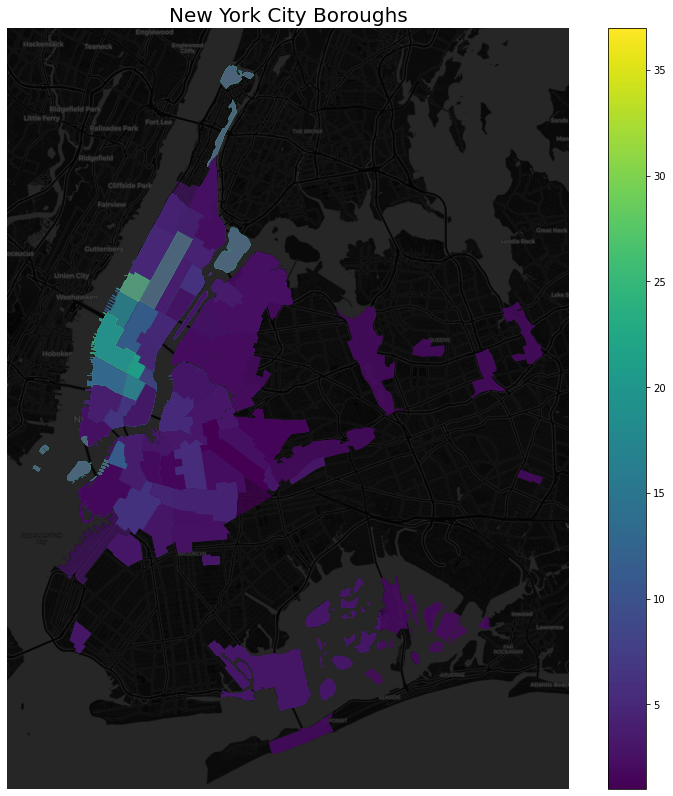

In [61]:
test_choro = bikes_in_nyc[(bikes_in_nyc['day'] == 1) & (bikes_in_nyc['hour'] == 12)]

test_choro.shape

fig, ax = plt.subplots(figsize=(14, 14))

test_choro.to_crs(epsg=3857).plot(
    ax=ax, 
    column='activity', 
    legend=True, 
    #cmap='Dark2', 
    alpha=0.7,
    )


# ctx.add_basemap(ax, url='https://{s}.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}.png')

ctx.add_basemap(ax, url='https://{s}.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}.png')


ax.axis('off')

ax.set_title('New York City Boroughs', fontdict={'size': 20});

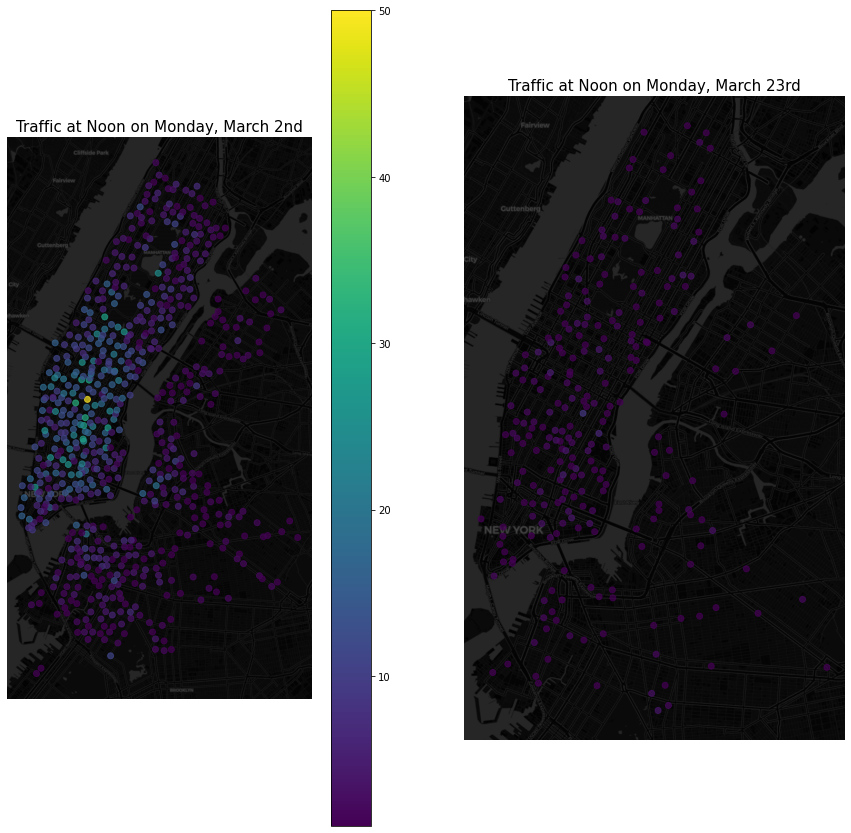

In [62]:
df_citibike_2_12 = df_citibike[(df_citibike['day'] == 2) & (df_citibike['hour'] == 12)]

fig, ax = plt.subplots(figsize=(15, 15))

ax = plt.subplot(1, 2, 1)
df_citibike_2_12.to_crs(epsg=3857).plot(
    ax=ax, 
    column='activity', 
    legend=True, 
#     label = column,
#     legend_kwds={'label': "Population by Country",
#                         'location': "2"},
#     legend_kwds={
#         'loc': 2,
#         'shadow': True
#     },
    #cmap='Dark2', 
    alpha=0.7,
    vmax = 50
    )

# plt.legend()

# ctx.add_basemap(ax, url='https://{s}.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}.png')
ctx.add_basemap(ax, url='https://{s}.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}.png')
ax.axis('off')
ax.set_title('Traffic at Noon on Monday, March 2nd', fontdict={'size': 15});



df_citibike_23_12 = df_citibike[(df_citibike['day'] == 23) & (df_citibike['hour'] == 12)]

# fig, ax = plt.subplots(figsize=(13, 13))
ax = plt.subplot(1, 2, 2)
df_citibike_23_12.to_crs(epsg=3857).plot(
    ax=ax, 
    column='activity', 
#     legend=True, 
#     label = column,
#     legend_kwds={
#         'loc': 2,
#         'shadow': True,
#         # 'facecolor': 'lightgray',
#     },
    #cmap='Dark2', 
    alpha=0.7,
    vmax=50
    )

# plt.legend()

# ctx.add_basemap(ax, url='https://{s}.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}.png')
ctx.add_basemap(ax, url='https://{s}.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}.png')
ax.axis('off')
ax.set_title('Traffic at Noon on Monday, March 23rd', fontdict={'size': 15});

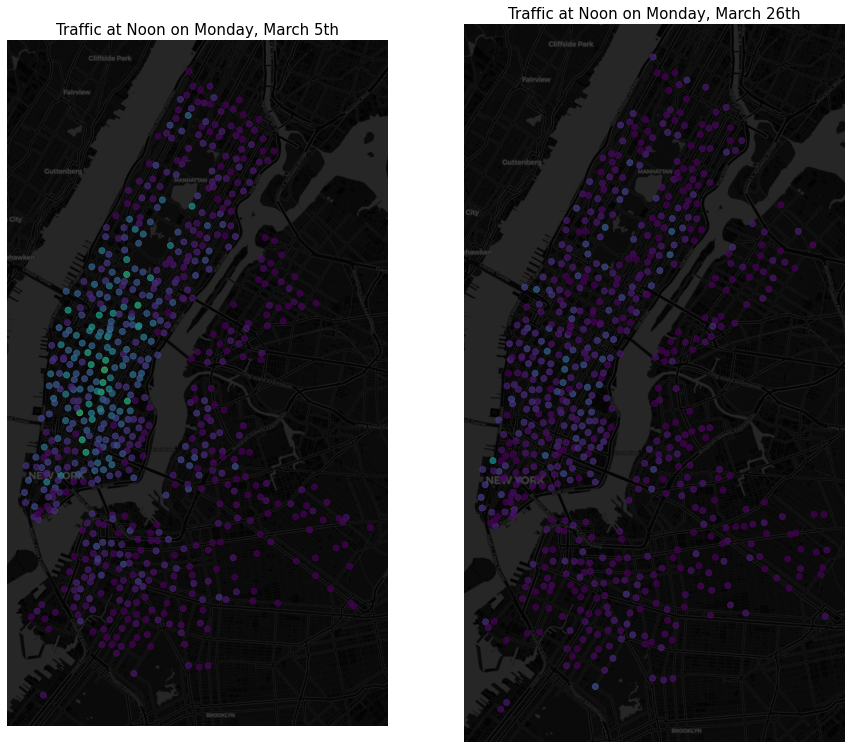

In [63]:
df_citibike_5_12 = df_citibike[(df_citibike['day'] == 5) & (df_citibike['hour'] == 12)]

fig, ax = plt.subplots(figsize=(15, 15))

ax = plt.subplot(1, 2, 1)
df_citibike_5_12.to_crs(epsg=3857).plot(
    ax=ax, 
    column='activity', 
#     legend=True, 
#     label = column,
#     legend_kwds={'label': "Population by Country",
#                         'location': "2"},
#     legend_kwds={
#         'loc': 2,
#         'shadow': True
#     },
    #cmap='Dark2', 
    alpha=0.7,
    vmax = 50
    )

# plt.legend()

# ctx.add_basemap(ax, url='https://{s}.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}.png')
ctx.add_basemap(ax, url='https://{s}.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}.png')
ax.axis('off')
ax.set_title('Traffic at Noon on Monday, March 5th', fontdict={'size': 15});



df_citibike_26_12 = df_citibike[(df_citibike['day'] == 26) & (df_citibike['hour'] == 12)]

# fig, ax = plt.subplots(figsize=(13, 13))
ax = plt.subplot(1, 2, 2)
df_citibike_26_12.to_crs(epsg=3857).plot(
    ax=ax, 
    column='activity', 
#     legend=True, 
#     label = column,
#     legend_kwds={
#         'loc': 2,
#         'shadow': True,
#         # 'facecolor': 'lightgray',
#     },
    #cmap='Dark2', 
    alpha=0.7,
    vmax=50
    )

# plt.legend()

# ctx.add_basemap(ax, url='https://{s}.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}.png')
ctx.add_basemap(ax, url='https://{s}.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}.png')
ax.axis('off')
ax.set_title('Traffic at Noon on Monday, March 26th', fontdict={'size': 15});

# sliders in Plotly - change over time- 1 day

In [64]:
import plotly.graph_objects as go

df_citibike_day21 = df_citibike[df_citibike['day'] == 21]

# activity_max/14

In [84]:
df.head()

index     station name  station latitude  station longitude  day  \
259947     775  1 Ave & E 16 St         40.732219         -73.981656   21   
259948    1342  1 Ave & E 18 St         40.733812         -73.980544   21   
259949  292029  1 Ave & E 44 St         40.750020         -73.969053   21   
259950  292235  1 Ave & E 68 St         40.765005         -73.958185   21   
259951    4478  1 Ave & E 78 St         40.771404         -73.953517   21   

        hour  number_pickups  number_dropoffs                       geometry  \
259947     0             1.0              1.0  POINT (989334.101 206044.065)   
259948     0             1.0              4.0  POINT (989641.982 206624.752)   
259949     0             0.0              1.0  POINT (992824.569 212530.637)   
259950     0             0.0              1.0  POINT (995833.217 217991.553)   
259951     0             1.0              3.0  POINT (997125.150 220323.576)   

        activity  net_pickups  
259947       2.0          0.0  
259948       5.0         -3.0  
259949       1.0         -1.0  
259950       1.0         -1.0  
259951       4.0         -2.0

In [83]:
import plotly.express as px
px.set_mapbox_access_token(open(".mapbox_token").read())
df = df_citibike_day21



fig = px.scatter_mapbox(df, lat="station latitude", lon="station longitude", 
#                         color="net_pickups",
                        size="activity",
                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=20, zoom=11,
                       animation_frame='hour', width=900, height=900)

fig.add_trace(px.scatter_mapbox(df, lat="station latitude", lon="station longitude",size=df['activity']*2,
                               opacity=0.1, color_discrete_sequence=["white"]).data[0])


fig.update_layout(mapbox_style="dark")

fig.show()
